![alt text](../figures/header.png "Logo Title Text 1")


# A Deep Dive into Geospatial Analysis

Many of the datasets that data scientists handle have some kind of geospatial component to them, and that information is oftentimes useful-to-critical for understanding the problem at hand. As such, an understanding of spatial data and how to work with it is a valuable skill for any data scientist to have. Even better, Python provides a rich toolset for working in this domain, and recent advances have greatly simplified and consolidated these.

In this tutorial we will take a deep dive into geospatial analysis in Python, using tools like `geopandas`, `shapely`, and `pysal` to analyze a dataset, provided by [Kaggle](https://www.kaggle.com/airbnb-data/boston-airbnb-open-data) (and originally from [Inside AirBnB](http://insideairbnb.com/get-the-data.html)), of sample AirBnB locations in Boston, Massachusetts.

This tutorial is targeted at folks who know a thing or two about data but haven't used Python's geospatial data tools just yet. As such, it assumes a high level of familiarity with `pandas`. Some familiarity with `scikit-learn`, `statsmodels`, `matplotlib`, and `seaborn` is also helpful.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
pd.set_option("max_columns", None)

## Table of Contents

* [**Plotting Points**](#Plotting-Points)
* [**Plotting Geometries**](#Plotting-Geometries)
* [**Upconverting `DataFrame` to `GeoDataFrame` Objects**](#Upconverting-DataFrame-to-GeoDataFrame-Objects)
* [**Plotting Geometries and Points**](#Plotting-Geometries-and-Points)
* [**Spatial Weights**](#Spatial-Weights)
* [**Spatial Lag**](#Spatial-Lag)
* [**Spatial Clustering**](#Spatial-Clustering)
* [**Spatial Regression**](#Spatial-Regression)
* [**Conclusion**](#Conclusion)
* [**Extra Credit**](#Extra-Credit)

## Plotting Points

First, let's boot up and examine our data. Since our data comes in a simple CSV file, we load it into a `pandas` `DataFrame`.

In [4]:
listings = pd.read_csv("../input/listings.csv")

In [5]:
# print a head


At the moment our listings have several geospatial variables, the most important of which are `longitude` and `latitude`, which give the exact coordinates of the BnB in question. This means that it's easy for us to, say, plot every BnB location on a map:

In [6]:
# plot the longitude and latitude 


Chances are you've already done this before, and it's a perfectly adequate way to get started working with locations. In this plot we see...not much, really. If you're very intimately familiar with the layout of the city of Boston, you will probably be able to make sense of some of these clusters which are, to me, not being from the city, totally mysterious.

In other words, this plot is missing something important: **geospatial context**.

Additionally, this display is **unprojected**&mdash;it's displayed in terms of raw coordinates. The amount of distance contained in a coordinate degree varies greatly depending on where you are, so this naive plot potentially pretty badly distorts distances.

We'll come back to the projection issue later; for now, there's an easy fix for both these problems.

Enter [`mplleaflet`](https://github.com/jwass/mplleaflet). `mplleaflet` is a tool that automatically takes a coordinate `matplotlib` plot of any kind and places it on top of a [`leaflet`](http://leafletjs.com/) slippy map. The best part is that it's just one additional line of code. Just throw `mplleaflet.display()` after generating your plot to drop it inline in your Jupyter notebook:

In [7]:
import mplleaflet

# take a subsample of points to computational fesibility 
sample = listings.sample(1000)

# use matplotlib to plot the long and lat of our subset

# use mplleaflet 

Note, however, that rather than plotting every single point on our map we've taken a sample of 1000 of them and plotted those. This is known as **undersampling**.

This is oftentime necessary, as here, for performance reasons. Because `mplleaflet` embeds point objects directly on an SVG canvas, it's as much as two orders of magnitude slower and more power-hungry than generating a really basic `matplotlib` blob.

There are few ways to get around this limitation. The [`bokeh`](http://bokeh.pydata.org/en/0.11.1/docs/user_guide/geo.html) library is classically mentioned as an option; the new, language-of-graphics-oriented (but still very incomplete) [`geoviews`](https://www.continuum.io/blog/developer-blog/introducing-geoviews) library does an even better job. And if you really, really need to see those points, you can use [`datashader`](http://datashader.readthedocs.io/en/latest/), another not-even-a-year-old visualization library that comfortably works with millions of points ([further reading](https://anaconda.org/jbednar/nyc_taxi/notebook)).

However, in our case we'll do...none of these things. We're not really interested in individaul BnBs, *per se*; we're interested in grouping them and finding similarities and trends amongst them, not what exact street they're on. To do this, we'll wrap these points in polygons of some kind and try to look not at homes, but at neighborhoods.

## Plotting Geometries

The world around us is split up into lots of different kinds of geometries. The big ones are continents; from there we go down to countries, states, districts, counties, and so on.

On the city level, where we are in this case, there are usually a bunch of federal options (PUMAs or electoral districts for example) as well as a variety of usually more targetted geographical aggregations provided by the city government. Usually no matter where you go, however, the lowest-level geometries in the United States are **census tracts**. Census tracts are created every ten years for the census, and are built to try to contain either 4000 or 0 people (in the case of parks, beaches, etc.).

Boston GIS released [data](http://www.arcgis.com/home/item.html?id=5628bfda9466438491219f4d07488a1e) on the census tracts in their city not long after the 2010 census went out, and that's what we'll use.

However, the data comes in the form of a complex and convoluted GIS-standard data format known as a `shapefile` ([further reading](https://en.wikipedia.org/wiki/Shapefile)).

`pandas` has no facilities for reading shapefiles.

When Wes McKinney was first introducing `pandas` to a wider audience, he was asked more than once why he was doing it when everyone was getting along so well passing raw `numpy` arrays back and forth all the time (remember, hindsight is 20/20). Reading shapefiles into Python used to be a similarly terrible experience, until [`geopandas`](http://geopandas.org/) came along and changed everything for the better.

Now you don't need to know anything at all about shapefiles to work with them, you just do this:

In [12]:
import geopandas as gpd

In [13]:
boston = gpd.read_file("../input/Census2010_Tracts.shp")

And you're done!

In [8]:
# print a head

`geopandas` extends `pandas` `DataFrame` and `Series` expressions into `GeoDataFrame` and `GeoSeries` ones.

The main thing that these add is a `geometry` column containing all of our shapes:

In [15]:
boston['geometry'].head()

0    POLYGON ((766978.240309909 2951616.923866287, ...
1    POLYGON ((766835.3942200691 2949104.969886944,...
2    POLYGON ((769261.2628526837 2954196.132479325,...
3    POLYGON ((772221.7065478563 2953536.652079985,...
4    POLYGON ((762449.9770828187 2952359.446074486,...
Name: geometry, dtype: object

However, these polygons seem more than a little bit weird. The coordinates don't make any sense!

It turns out that the shapefile we're working with is encoded in some kind of alternative **coordinate reference system** (CRS), one with the origin point set to (200000, 750000). We can see this for ourselves by asking our `GeoDataFrame` its `crs` property:

In [16]:
boston.crs

{u'datum': u'NAD83',
 u'lat_0': 41,
 u'lat_1': 41.71666666666667,
 u'lat_2': 42.68333333333333,
 u'lon_0': -71.5,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 199999.9999999999,
 u'y_0': 750000}

The master directory for all well-known coordinate systems is the **EPSG**. The simple latitude-and-longitude reference system is `epsg:4326`, and `geopandas` makes it really, really easy to "fix" our coordinates by just calling the `to_crs` method:

In [17]:
boston = boston.to_crs({'init': 'epsg:4326'})

In [18]:
boston['geometry'].head()

0    POLYGON ((-71.090087 42.34665699999989, -71.09...
1    POLYGON ((-71.09065999999994 42.33976599999991...
2    POLYGON ((-71.08159499999989 42.35370399999986...
3    POLYGON ((-71.070655 42.35185399999991, -71.07...
4    POLYGON ((-71.10682499999994 42.34875299999984...
Name: geometry, dtype: object

Much better.

`geopandas` objects have a `plot` method which plops your geometry into a `matplotlib` plot right away:

In [9]:
# plot boston geodataframe


Again, to get geographic context, let's throw this result at `mplleaflet`!

In [23]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
boston.plot(ax=ax)
mplleaflet.display(fig=f)

There it is&mdash;all the census tracts of the city of Boston.

Notice that some of these tracts have really "weird" shapes. This is because these are census tracts, remember, which try to isolate parts of the city which have people in them from those (like airports, beaches, islands, or the waterway) which do not.

## Upconverting `DataFrame` to `GeoDataFrame` Objects

Under the hood, `geopandas` represents geometries using the [`shapely`](https://github.com/Toblerity/Shapely) library. Just like how when using `pandas` you still occassionally have to reach across to grab something from `numpy`, when working with geometries it's important to understand what `shapely` nets you.

In [24]:
import shapely

Luckily `shapely` has some of the best [documentation](http://toblerity.org/shapely/manual.html) of any library I've ever used, and it's really simple to use.

Recall that our BnB listings was a `DataFrame` containing two geospatial fields, latitude and longitude. As a quick demonstration of `shapely`, let's upconvert this representation to true geometries. To do this we wrap our `DataFrame` in a `GeoDataFrame`, mapping our `geometry` column to a `shapely` `Point` for each coordinate pair.

In [25]:
listings = gpd.GeoDataFrame(listings, geometry=listings.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))

## Plotting Geometries and Points

We've plotted our points and our polygons seperately, now how do we bring them together?

One obvious answer is to use a `seaborn` [`kdeplot`](http://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot), which many of you should be familiar with.

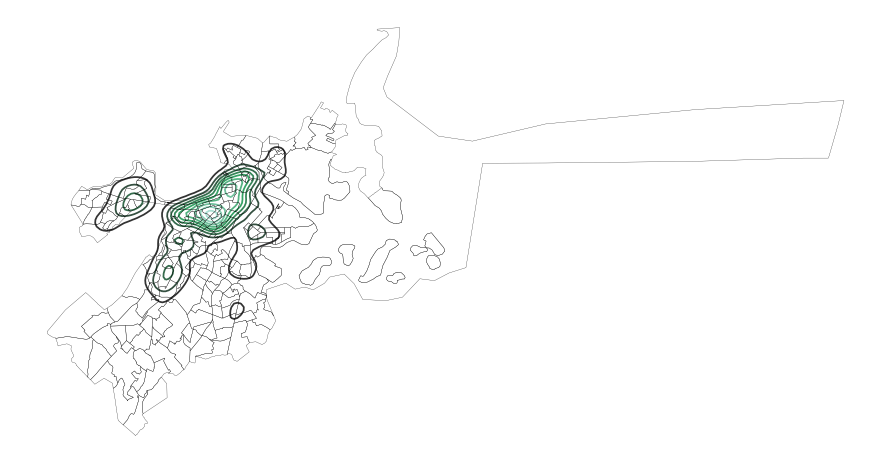

In [26]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

boston.plot(ax=ax, alpha=0.1, linewidth=0.25, color='white')
sb.kdeplot(data=listings.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'), ax=ax,
            alpha=1)
ax.set_axis_off()

This does give us a good sense of where our AirBNBs are concentrated. Unfortunately, however, KDEs are almost always too "blobish"&mdash;they're not granular enough to show the details inherent in geographic distributions.

With a little bit more work we can get to the closest thing to a gold standard for such things in cartography, a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map).

First let's create a column in our polygonal dataset, `BNBs`, containing a count of the number of AirBnB locations in the area.

In [27]:
import numpy as np

def assign_census_tract(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in boston['geometry']]
    if True in bools:
        return boston.iloc[bools.index(True)]['NAMELSAD10']
    else:
        return np.nan

In [28]:
# apply assign_census_tract to our 'listings' dataframe
# save the result to listings['census_tract'] 

In [29]:
# call .value_counts().head() on the above result
listings['census_tract'].value_counts().head()

Census Tract 701.01    113
Census Tract 102.03    111
Census Tract 8.02       95
Census Tract 201.01     86
Census Tract 606        84
Name: census_tract, dtype: int64

In [30]:
boston['BNBs'] = boston['NAMELSAD10'].map(listings['census_tract'].value_counts())

And now we use that data to throw up a map.

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


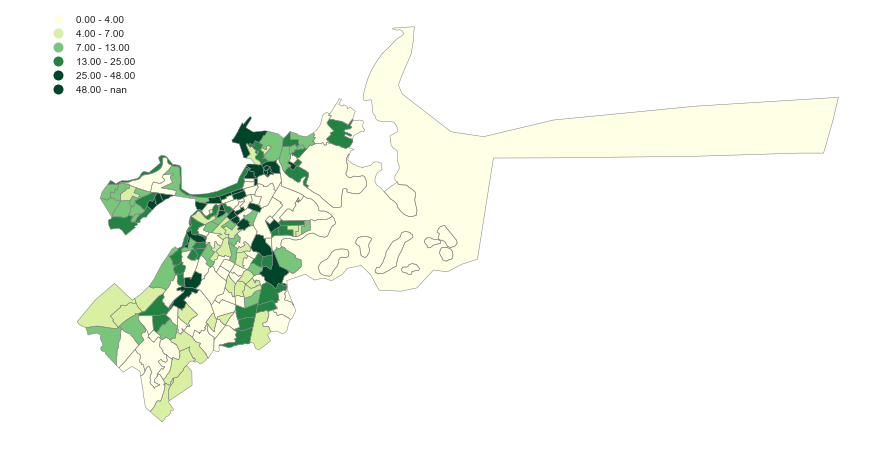

In [32]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='BNBs', 
          k=6, 
          cmap='YlGn', 
          alpha=1, 
          legend=True, 
          edgecolor='gray', 
          linewidth=0.5)

boston.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

This type of map is, as was mentioned earlier, known as a choropleth. It's a ubiquitious classic of the genre. The darker the shading, the more AirBNBs in that census tract.

Aside from a variety of visual parameters, we specified three important ones. `column=BNBs` told `geopandas` which columns to plot data from. `scheme=QUANTILES` is which "bucketing" system you want to plot with: in this case we specified [quantiles](https://en.wikipedia.org/wiki/Quantile), which splits the data into bins equal in *number*, albiet not in *size*. Finally, `k` tells `geopandas` how many bins we want.

The trouble with this map, however, is that it doesn't take into account the *size* of the census tracts. If our census tract is bigger than average, it'll naturally contain more homes, and, all else being equal, more AirBnBs.

This is a classical mapmaking fallacy. Here's another example of this error, straight from the responsible article on Wikipedia:

![alt text](../figures/choropleth-mistake.png "Logo Title Text 1")

Notice how the plot on the left is completely scrambled and doesn't actually tell us anything, while the plot on the right is smooth, structured, and informative.

In our case we'll fix it by figuring out AirBnB density per square kilometer, not just the raw number, and plot that.

Remember, however, that areas in the latitude-longitude coordinate system are not equal. To get an accurate measurement of area we need to first reproject to what's called an "equal-area" projection (`epsg:3395` will do nicely), and then take the areas of *those* polygons instead. Note also that `shapely` returns areas in square meters; we divide by a constant to get square kilometers. All this is done by the workhourse one-liner below.

In [34]:
boston['BNBDensity'] = (boston['BNBs'] / boston['geometry']\
                            .to_crs({'init': 'epsg:3395'})\
                            .map(lambda p: p.area / 10**6))\
                            .fillna(0)

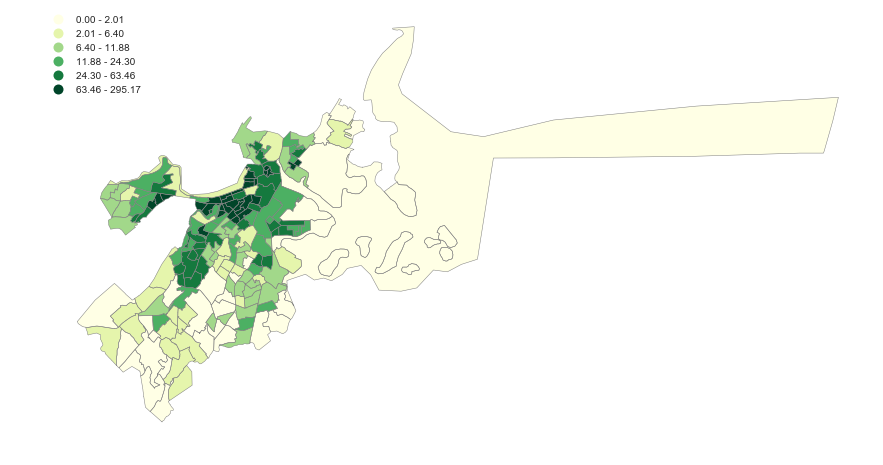

In [35]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
kw = dict(column='BNBDensity', k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
boston.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

This more contiguous plot is the correct one!

Here we see that in the inner city AirBnB density reaches from 60 to almost 300 AirBnB locations per square kilometer. Since there are [approximately 150](http://www.convertunits.com/from/square+kilometer/to/square+city+block+[East+U.S.]) city blocks per kilometer squared, a back-of-the-envelope calculation says that this makes for anywhere from an AirBnB every three blocks to two AirBnBs per block.

That's a lot of market penetration.

## Spatial Weights

We will now introduce the next major tool in the geographic toolbox, [`pysal`](http://pysal.readthedocs.io/en/v1.11.0/). `pysal` is a by-now venerable library designed for performing spatial analytics, and it'll be our focus for the remainder of this tutorial.

In [37]:
import pysal as ps

Spatial data analytics requires understanding spaces, and understanding spaces requires tying them together somehow. Thus the concept of **spatial weights**.

Spatial weights tie together areas which are neighbors with one another in some sense. There are many ways of defining this concept of neighborhood-ness or closeness. We could, for example, pick all of the other shapes which are within a certain distance of our chosen shape. Or we could choose all shapes which directly border ours, or at least touch ours. The former of these is known as rook continuity and the latter as queen continuity, after the way those pieces move on a checkerboard, and they're two of the most common methods for defining spatial weights.

If you're interested in more details, you definitely need to check out [the concept's entry](http://darribas.org/gds_scipy16/ipynb_md/03_spatial_weights.html) in the `pysal` documentation.

For ease of use, we'll pick queen continuity. This means that we will consider our census tracts to be neighbors so long as they touch at least at an edge. We can read such facts directly out of the shapefile using `queen_from_shapefile`:

In [38]:
qW = ps.queen_from_shapefile("../input/Census2010_Tracts.shp")

This tells us that, for instance, our fourth census tract has four "touching" neighbors: tracts 6, 10, 50, and 80:

In [39]:
qW[4]

{6: 1.0, 10: 1.0, 50: 1.0, 80: 1.0}

To get a better sense of what we've just created, let's plot our neighborhood vectors on a map:

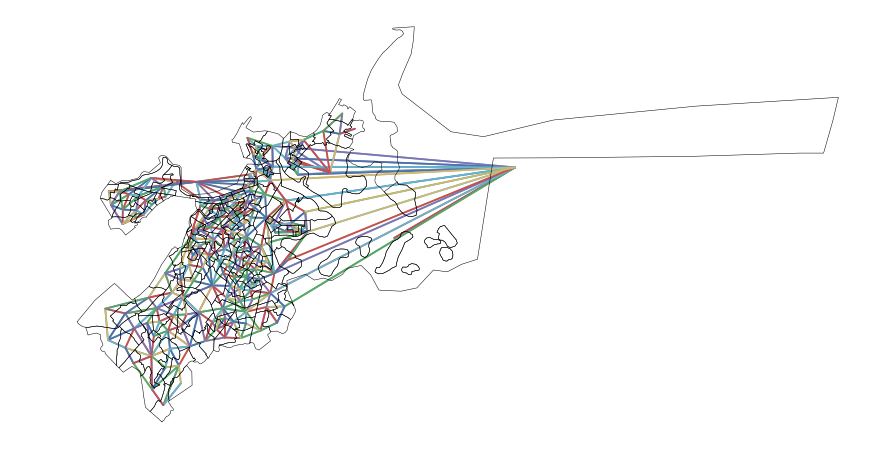

In [40]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

for i, (k, neighbors) in enumerate(qW.neighbors.items()):
    origin = boston.geometry.iloc[i].centroid
    for nabe_i in neighbors:
        nabe_centroid = boston.geometry.iloc[nabe_i].centroid
        plt.plot([origin.x, nabe_centroid.x], [origin.y, nabe_centroid.y], '-')

boston.plot(ax=ax, linewidth=0.5, facecolor='white')

ax.set_axis_off()

You can see it better when you zoom in a bit:

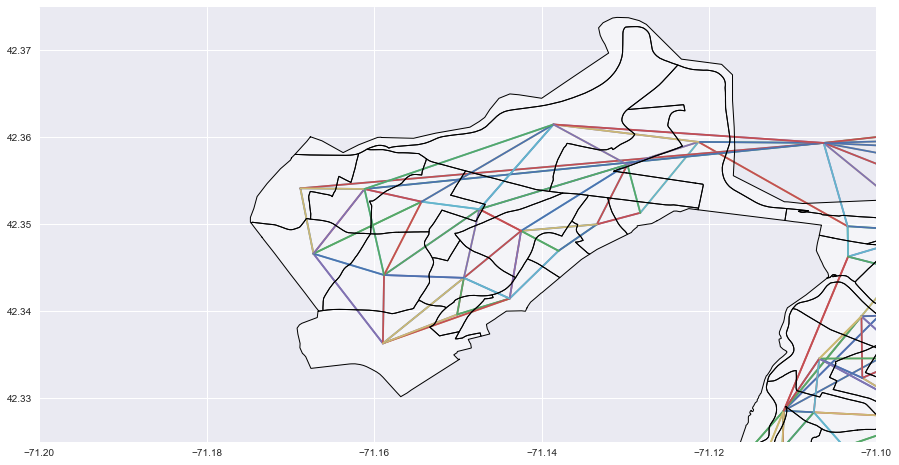

In [42]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

for i, (k, neighbors) in enumerate(qW.neighbors.items()):
    origin = boston.geometry.iloc[i].centroid
    for nabe_i in neighbors:
        nabe_centroid = boston.geometry.iloc[nabe_i].centroid
        plt.plot([origin.x, nabe_centroid.x], [origin.y, nabe_centroid.y], '-')

boston.plot(ax=ax, linewidth=1, facecolor='white')

ax.set_xlim([-71.2, -71.1])
ax.set_ylim([42.325, 42.375]);

...including the weirdness around the elongated census tract for that strip of beach.

## Spatial Lag

Spacial weights are necessary in order to get a sense of the **spatial lag** inherent in our data. Spatial lag is a geographic version of autocorrelation, a perhaps familar term from time-series analysis: it's a measure of how strongly the data in one polygon is predicted by its neighbors.

If our data is totally randomly distributed on the map&mdash;if, in effect, it has *no* spatial component&mdash;then we expect that the BnB densities in our neighboring census tracts will be very poor predictors of the BnB density in our current tract, because we'll just be predicting noise with noise. If, on the other hand, the densities we predict are close to the real value, then we *can* predict density based on geography, and our data does indeed have a strong geographic component.

Of course, examining our plots from earlier, this may seem like a moot point&mdash;the choropleths make it pretty obvious that there's geography involved. But what we'd like to do now is assign a probability to that geography not being just random chance. Examining spatial lag allows us, essentially, to understand the **statistical significance** of our result.

Let's generate lags, split them into five quantiles, and see where they end up.

In [43]:
bnb_spatial_lags = ps.lag_spatial(qW, boston['BNBDensity'])
spatial_lag_classes = ps.Quantiles(bnb_spatial_lags, k=5)

In [44]:
spatial_lag_classes

                 Quantiles                  
 
 Lower              Upper              Count
           x[i] <=   24.421               37
  24.421 < x[i] <=   59.602               36
  59.602 < x[i] <=  136.943               36
 136.943 < x[i] <=  281.667               36
 281.667 < x[i] <= 1132.690               36

In [45]:
spatial_lag_classes.yb

array([4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 3,
       3, 2, 4, 4, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 3, 4, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 3,
       3, 2, 1, 0, 4, 3, 1, 3, 2, 2, 3, 4, 4, 3, 1, 3, 4, 0, 0, 0, 2, 0, 0,
       1, 1, 4, 4, 4, 4, 4, 3, 4, 4, 2, 3, 2, 3, 2, 0, 1, 0, 3, 2, 2, 3, 1,
       3, 2, 2, 3, 2, 2, 2, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 1, 2,
       3, 2, 3, 1, 4, 2, 2, 2, 2, 1, 1, 3, 4, 4, 4, 4, 4, 3, 4, 2])

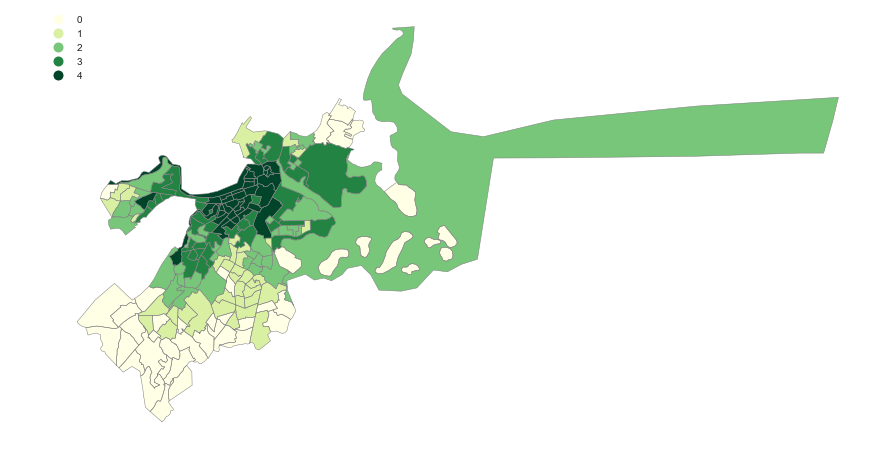

In [46]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='spatial_class', 
          k=5, cmap='YlGn', 
          alpha=1, legend=True, 
          edgecolor='gray', 
          linewidth=0.5, 
          categorical=True)

boston.assign(spatial_class=spatial_lag_classes.yb).plot(ax=ax, **kw)
ax.set_axis_off()

This geographic pattern is distinctly *not* random, strong evidence again that our data is geographically dependent.

How dependent? The tool of choice for this is the a Moran scatterplot. If geography matters our data should show a strong liner structure of some kind: high lag values correspond with high actual values, and low lags with low ones.

A quick plot shows that this is, indeed, the case:

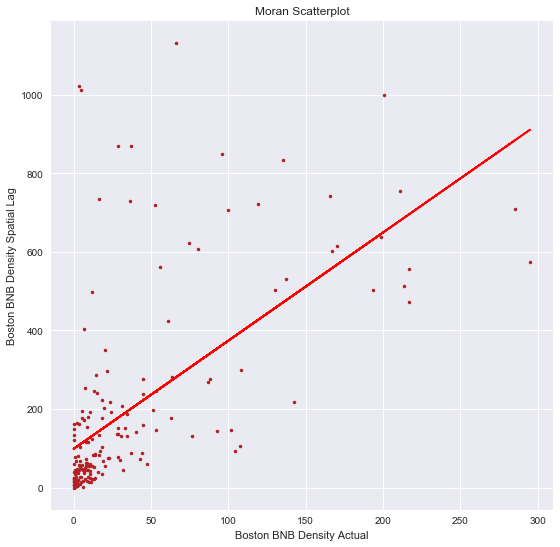

In [47]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.plot(boston['BNBDensity'], bnb_spatial_lags, '.', color='firebrick')

# Calculate and plot a line of best fit.
b,a = np.polyfit(boston['BNBDensity'], bnb_spatial_lags, 1)

plt.plot(boston['BNBDensity'], a + b*boston['BNBDensity'], 'r')

plt.title('Moran Scatterplot')
plt.ylabel('Boston BNB Density Spatial Lag')
plt.xlabel('Boston BNB Density Actual')
plt.show()

We can get a p-value:

In [48]:
moran = ps.Moran(boston['BNBDensity'].values, qW)
moran.I, moran.p_sim

(0.52791245490442451, 0.001)

Our p-value of 0.001 tells us that there is a less than 0.1% chance that our data distribution is this heavily skewed by randomness alone.

## Spatial Clustering

We've learned how to display geography and how to measure its importance for a dataset. Let's now move on to learning how to apply it.

Suppose that we're interested in segmenting the Boston AirBnB markets based on the types of properties available. This is, after all, a part of our dataset:

In [49]:
listings['property_type'].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

Leaving aside the "exotic" options, we've really got two major types of BnBs: apartments and houses.

In [50]:
apartments = listings.query('property_type == "Apartment" or property_type == "Condominium"').groupby('census_tract').count()['id']
houses = listings.query('property_type == "House" or property_type == "Townhouse"').groupby('census_tract').count()['id']

Let's create numerical variables counting how many of each we have per census tract.

In [51]:
boston['BNBDensity_Houses'] = boston['NAMELSAD10'].map(houses).fillna(0)
boston['BNBDensity_Apartments'] = boston['NAMELSAD10'].map(apartments).fillna(0)

We have three predictor variables that we'd like to use: the number of apartments, the numbers of houses, and their density combined.

In [52]:
bnb_market = boston[['BNBDensity', 'BNBDensity_Houses', 'BNBDensity_Apartments']]

If you're familiar with `scikit-learn` this is, at this point, a classic clustering problem, one we can easily solve using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering), for example:

In [53]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# create a KMeans object with 3 clusters

# scale bnb_market values and save to variable "X"

# fit your model


But remember that we're dealing with geometries, not just points in space! Our clustering algorithm doesn't know about this; it just naively classifies even very distant tracts into bins based on characteristic similarity alone. We can see this when we plot the result:

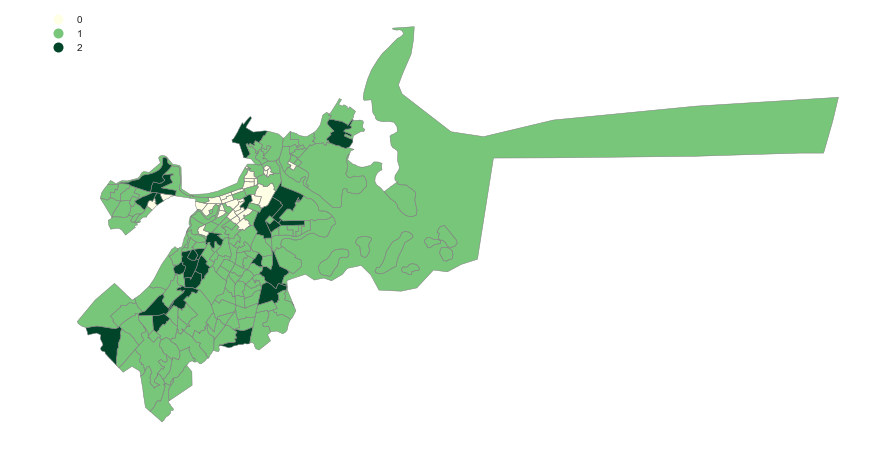

In [54]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='cluster', 
          k=3, cmap='YlGn', 
          alpha=1, 
          legend=True, 
          edgecolor='gray', 
          linewidth=0.5, 
          categorical=True)

boston.assign(cluster=classes.labels_).plot(ax=ax, **kw)
ax.set_axis_off()

Our classifier does seem to have learned, in effect, the difference between low-density outlying tracts, medium-density tracts, and high-density inner city tracts:

In [55]:
bnb_market.assign(cluster=classes.labels_).groupby('cluster').mean()

,BNBDensity,BNBDensity_Houses,BNBDensity_Apartments
cluster,,,
0,149.154101,1.571429,47.464286
1,12.233624,2.062992,6.740157
2,31.235665,11.615385,23.884615


Indeed, this classifier does exactly what we set out to do. Examine the following plot:

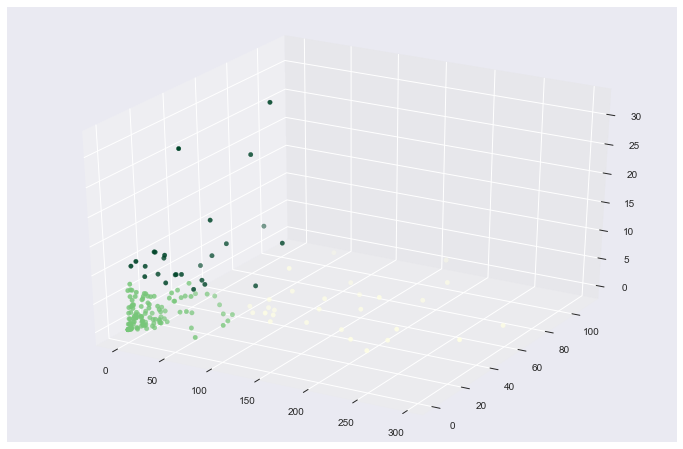

In [58]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bnb_market['BNBDensity'], 
           bnb_market['BNBDensity_Apartments'],
           zs=bnb_market['BNBDensity_Houses'],
           c=classes.labels_, 
           cmap='YlGn');

The pale census tracts are those which have very little AirBnB activity at all. They tend to be furthest from the city center. The second class of tracts, the dark green ones, have a significant BnB density, but consist primarily of houses, not apartments; these correspond with middle-of-the-pack residential areas. Finally, the densest areas, tracts containing plenty of apartments for rent but no homes and located in the heart of the city, are pale green.

This is perfect! Right?

Well, it is, except that the areas we've binned are discontinuous. Because our classifier disregards geography it doesn't put in any effort keeping our class members next one another, and so we don't arrive at any understanding of neighborhood topography.

`pysal` contains classifiers that allow us to do just that. Cheif amongst them is the `Maxp` clustering algorithm, which chooses clusters which match each other characteristically *and* are also all next to one another (according to whatever definition of neighbors you choose&mdash;we'll keep going with queen contiguity).

Here's what we get when we run it. Notice the place of our spatial weights in the input, as well as a minimum number of observations per class&mdash;150.

In [59]:
clf = ps.region.Maxp(qW, bnb_market.values, 150, boston['BNBs'].values[:,None])

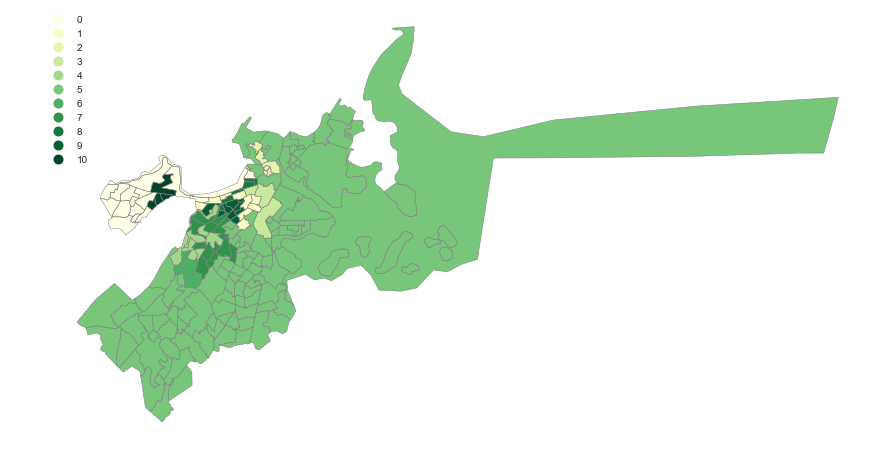

In [60]:
# n = 200
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='cluster', 
          k=10, 
          cmap='YlGn', 
          alpha=1, 
          legend=True, 
          edgecolor='gray', linewidth=0.5, categorical=True)

boston.assign(cluster=clf.area2region.values()).plot(ax=ax, **kw)
ax.set_axis_off()

Because of the additional constraint the algorithm imposes, it tends to result in significantly more clusters than comparable non-spatial clustering algorithms. But, as you can see here, the algorithm did arrive at essentially the same conclusion as our kNN did: apartment-dense inner cities, house-dense middle burbs, and outlying areas. It just takes ten contiguous districts to describe what three discontiguous ones.

Here again are our mean characteristics:

In [61]:
bnb_market.assign(cluster=clf.area2region.values()).groupby('cluster').mean()

,BNBDensity,BNBDensity_Houses,BNBDensity_Apartments
cluster,,,
0,19.043128,4.750000,12.187500
1,90.529983,1.777778,41.111111
2,121.960229,2.333333,24.333333
3,25.149287,2.000000,47.666667
4,47.332745,5.250000,20.625000
5,10.564003,2.906542,6.420561
6,38.868245,14.000000,33.666667
7,16.239644,3.272727,10.272727
8,229.261079,1.166667,53.500000


## Spatial Regression

Suppose that we're interested in modeling the price of a BnB. Let's use the following basic features to do it:

In [62]:
explanatory_variables = ['bathrooms', 'bedrooms', 'beds', 'guests_included']

There's a lot of boilerplate here (note the need to merge together the `price` and `cleaning fee` into an `actual_price`, BnB hosts like to be sneaky and sock away as much as 50$ or more into that "fee"!). But if you've run a basic linear regression before, this should be pretty rote. We're going to use `statsmodels` to do it.

In [65]:
import statsmodels.api as sm

def convert_price(price):
    try:
        return float(price.replace("$", "").replace(".", "")[:-2])
    except (ValueError, AttributeError):
        return np.nan


price_variables = ['price', 'cleaning_fee']
geom = ['latitude', 'longitude']  # we'll need this later
valid_listings = listings[explanatory_variables + price_variables + geom].dropna()
valid_listings['actual_price'] = valid_listings['price'].map(convert_price) +\
                                 valid_listings['cleaning_fee'].map(convert_price)
valid_listings = valid_listings.dropna()

# build Ordinary Least Squre model using statesmodels
# use valid_listings['actual_price'] as X
# use valid_listings[explanatory_variables] as Y

In [11]:
# print out the statistical summary

Now how do we take this analysis and make it spatial?

A common theme found in the field of spatial econometrics is the idea of mutual price-setting. That is, when someone sets the price of a spatial good, they take into account the price that good set by their neighbors, and vice versa.

If price-setting has a spatial element of this kind (a beating-the-Joneses effect of sorts), then we should be able to improve the results of our model by mixing in observations about nearby BnBs.

To do that we'll first need to grab ahold of what we mean by "neighbors". Since we're dealing with points, not shapes, contiguities don't apply here anymore; we in our usual k-nearest neighbor space. It's possible to grab our kNN from `scipy`, but it's much faster coding-wise to take a `pysal` built-in instead.

In [67]:
w = ps.knnW_from_array(valid_listings[['longitude', 'latitude']].dropna().values, k=2)
w

Then to run our spatial regression we simply pass in the same parameters as before, but now with the inclusion of our weights (`w`). `name_x` and `name_y` are optional parameters which simply add a little bit more information to the summary display.

In [68]:
geospatial_ols = ps.spreg.GM_Lag(valid_listings['actual_price'].values[:, None],
                                 valid_listings[explanatory_variables].values,
                                 w=w,
                                 name_x=explanatory_variables,
                                 name_y='actual_price')

In [69]:
print(geospatial_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :actual_price                Number of Observations:        2460
Mean dependent var  :    246.6793                Number of Variables   :           6
S.D. dependent var  :    145.2765                Degrees of Freedom    :        2454
Pseudo R-squared    :      0.2996
Spatial Pseudo R-squared:  0.3265

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      74.5257846      11.4683038       6.4984139       0.0000000
           bathrooms      48.5721848       6.0617495       8.0128988       0.0000000
            bedrooms      39.4847512       4.7342175       

Unfortunately we will end our crash course on a sad note. it doesn't look like neighbor price fixing is a significant variable at all, as our coefficient is on the level of statistical noise.

Furthermore, it turns out that our spatial algorithm is significantly *worse*; the mean squared error of our spatial result, a common metric for OLS regression, is much worse than for our no-frills one:

In [70]:
geospatial_ols_mse = ((valid_listings['actual_price'] - geospatial_ols.predy.flatten()) ** 2).mean()
print("OLS".ljust(5), ":", basic_ols_res.mse_total)
print("OLS+W".ljust(5), ":", geospatial_ols_mse)

('OLS  ', ':', 81947.352439024384)
('OLS+W', ':', 14788.387329874146)


So in this case we've shown pretty conclusively just the opposite: that the price of a BnB has little to do with the prices set by its neighbors.

## Conclusion

That concludes our crash course on geospatial data science. There's lots of useful components in the Python toolbox that we *didn't* cover: working with images using `rasterio`, for example. But I hope that this quick crash course has at least made you aware of some of the many interesting geographic things you can do with the tools that Python has! Keep them in mind&mdash;they're sure to come in handy later.

If you want to learn more about Python geospatial tools, here's a only loosely-ordered list of resources to look at:

* https://www.youtube.com/watch?v=HzPSVwyP2Y0
* https://www.youtube.com/watch?v=TY4QWnnd4jY&t=9697s
* http://darribas.org/gds_scipy16/ (in large part the inspiration for this piece!)
* http://www.ngs.noaa.gov/GEOID/PRESENTATIONS/2007_02_24_CCPS/Roman_A_PLSC2007notes.pdf
* https://www.youtube.com/watch?v=6m3CFbKmK_c
* https://www.youtube.com/watch?v=L_uJvLKHgEs
* http://toblerity.org/shapely/manual.html
* http://geojson.org/geojson-spec.html
* https://mapbox.github.io/rasterio/

## Extra Credit

If you're up for a challenge, the dataset also includes information on the amenities present at each location:

In [71]:
amenities = listings['amenities'].map(lambda d: [amenity.replace('"', "")\
                                                        .replace("{", "")\
                                                        .replace("}", "") for amenity in d.split(",")])
listings['amenities'] = amenities
possible_amenities = set([item for sublist in amenities for item in sublist])
possible_amenities

{'',
 '24-Hour Check-in',
 'Air Conditioning',
 'Breakfast',
 'Buzzer/Wireless Intercom',
 'Cable TV',
 'Carbon Monoxide Detector',
 'Cat(s)',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'Elevator in Building',
 'Essentials',
 'Family/Kid Friendly',
 'Fire Extinguisher',
 'First Aid Kit',
 'Free Parking on Premises',
 'Free Parking on Street',
 'Gym',
 'Hair Dryer',
 'Hangers',
 'Heating',
 'Hot Tub',
 'Indoor Fireplace',
 'Internet',
 'Iron',
 'Kitchen',
 'Laptop Friendly Workspace',
 'Lock on Bedroom Door',
 'Other pet(s)',
 'Paid Parking Off Premises',
 'Pets Allowed',
 'Pets live on this property',
 'Pool',
 'Safety Card',
 'Shampoo',
 'Smoke Detector',
 'Smoking Allowed',
 'Suitable for Events',
 'TV',
 'Washer',
 'Washer / Dryer',
 'Wheelchair Accessible',
 'Wireless Internet',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50'}

Analysis by the `pysal` folks showed that, at least in Austin, the presence of a pool amenity somewhere nearby had a small but significant effect on price.

Does this result extend to Boston? And do any of the other amenities have an effect like this as well?

----

# Credit

[**ResidentMario **](https://github.com/ResidentMario)  **This notebook is the original work of Aleksey Bilogur** who goes by ResidentMario on Github. All credit for the content in this notebook belongs to him. You can check out this notebook and other great work by Aleksey Bilogur on his Github Repo. 
